In [40]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys
from rdkit import Chem, DataStructs

from xgboost import XGBRegressor

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, RepeatedKFold

## Intro

In this tutorial we will try differnt types of molecule encoding and transformations of the input data. We will try just few examples of many possibilities of data encoding.

# Load the DATA

In [2]:
df = pd.read_csv('data/VEGF2_ML_ready.csv')
df.head()

,smiles,label,ds
0,CCCOCc1ccc2c(c1)c1c3c(c4c(c1n2CCCO)Cc1ccccc1-4...,8,7.89
1,O=C(Nc1ccc(Nc2ncnc3sc4c(c23)CCCC4)cc1)Nc1ccc(C...,9,6.70
2,COc1cc2c(Nc3cccc4occc34)ncnc2cc1OCCCN1CCOCC1,8,6.60
3,CCc1cccc(NC(=O)Nc2ccc(-c3cccc4[nH]nc(N)c34)cc2)c1,9,8.22
4,COc1cccc(C(=O)CN2CCN(c3nnc(-c4ccccc4)c4ccccc34...,9,5.47


### Outliers

# Encoding molecules into the input vectors

### Character encoding
Let's check the lenghts of the data and filter the dataset
Vectors has to be of the same lenght, but we don't want them to be full of paddings
We will use filtered dataset for all other representation, so we can compare the results at the end

{'/', 'o', '4', 'B', '[', 'e', 'r', 'P', 'I', 'O', '6', 'i', 'F', '7', '-', 'S', '3', '2', '.', ')', 'C', 'H', '(', 'c', '\\', ']', '#', '=', 'N', 'n', '5', 's', '+', 'l', '@', '1'}
36


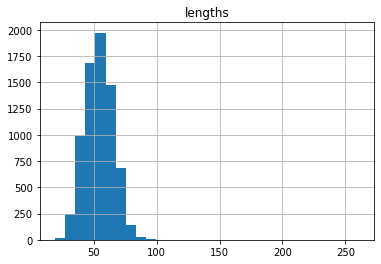

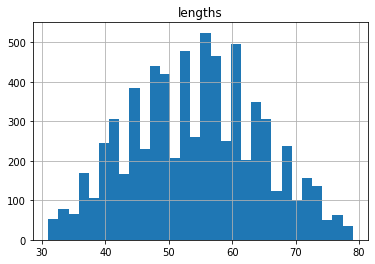

In [3]:
allchars = set("".join(list(df.smiles)))

# Let's start from 1, we will use zero for padding
char2int = dict((c,i+1) for i,c in enumerate(allchars))
int2char = dict((i+1,c) for i,c in enumerate(allchars))
df['lengths'] = [len(smile) for smile in df.smiles]

print(str(allchars))
print(len(allchars))
plot = df.hist('lengths', bins=30)
plt.show()

df_filtered = df[(df.lengths < 80) & (df.lengths > 30)].copy()
df_filtered.hist('lengths', bins=30)
plt.show()

In [4]:
max_len = np.max(df_filtered.lengths)
char_vec = np.zeros((df_filtered.smiles.shape[0], max_len),dtype=np.int8)
for i,smile in enumerate(df_filtered.smiles):
    for j,char in enumerate(smile):
        char_vec[i,j] = char2int[char]
char_vec = [vec for vec in char_vec]
df_filtered['char_vec'] = char_vec

### Morgan fingerprint

In [20]:
mols = [Chem.MolFromSmiles(smi) for smi in df_filtered.smiles]
mfps_1024_2 = [AllChem.GetMorganFingerprintAsBitVect(m, 2, 1024) for m in mols]
    
df_filtered['mfps_1024_2'] = mfps_1024_2

In [21]:
mols = [Chem.MolFromSmiles(smi) for smi in df_filtered.smiles]
mfps_1024_4 = [AllChem.GetMorganFingerprintAsBitVect(m, 4, 1024) for m in mols]
    
df_filtered['mfps_1024_4'] = mfps_1024_4

In [22]:
mols = [Chem.MolFromSmiles(smi) for smi in df_filtered.smiles]
mfps_2048_2 = [AllChem.GetMorganFingerprintAsBitVect(m, 2, 2048) for m in mols]
    
df_filtered['mfps_2048_2'] = mfps_2048_2

In [23]:
mols = [Chem.MolFromSmiles(smi) for smi in df_filtered.smiles]
mfps_2048_4 = [AllChem.GetMorganFingerprintAsBitVect(m, 4, 2048) for m in mols]
    
df_filtered['mfps_2048_4'] = mfps_2048_4

### MACC'S

In [9]:
maccs_fps = [Chem.MACCSkeys.GenMACCSKeys(mol) for mol in mols]
np_maccs_fps = []
    
df_filtered['maccs_fps'] = maccs_fps

### dimension reduction by PCA

In [10]:
pca = PCA(0.9)

### Save the DataFrame

In [11]:
# We can't save the dataframe to csv bcs we wont to preserve the datastructure of fingerprints
#joblib.dump(df, 'data/df_VEGF2_mfps_maccs.sav')
#print('DataFrame was saved')
joblib.dump(df_filtered, 'data/df_VEGF2_mfps_maccs_filtered_by_length.sav')
print('DataFrame was saved')

DataFrame was saved


# Regression with XGBoost

In [113]:
def get_tuned_model(X, y,):      
    params = {
            'min_child_weight': [1, 5, 10],
            'gamma': [0.1, 0.5, 1, 1.5,],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'n_estimators' : [100, 300, 400, 500, 600],
            'max_depth': [3, 4, 5]
            }
    
    xg_reg = XGBRegressor(objective='reg:squarederror', seed=0)
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    random_search = RandomizedSearchCV(xg_reg, 
                                       param_distributions=params, 
                                       n_iter=5,
                                       scoring='neg_mean_absolute_error', 
                                       n_jobs=-1, 
                                       cv=kf, 
                                       verbose=3, 
                                       random_state=0)

    print('best params for fp type ' + fp_type, random_search.best_params_)
    print('best score %.3f' %(np.abs(random_search.best_score_)))
          
    return random_search.best_estimator_

In [55]:
all_scores = []
all_models = []
all_test_scores = []
all_test_X = []
scaler = MinMaxScaler()

fps_types = ['char_vec', 'char_vec', 'maccs_fps', 'maccs_fps', 
            'mfps_1024_2', 'mfps_1024_4', 'mfps_2048_2', 'mfps_2048_4',
            'mfps_1024_2', 'mfps_1024_4', 'mfps_2048_2', 'mfps_2048_4']
counter = 0
to_pca = [3, 8, 9, 10, 11]
to_transform = [1]

scorings = ('r2', 'neg_mean_squared_error')
cv = RepeatedKFold(n_splits=2, n_repeats=5, random_state=0)
    
for fp_type in fps_types:
    
    X = [val for val in df_filtered[fp_type]]
    y = df_filtered.ds
    train_X, test_X, train_y, test_y = train_test_split(X, y,
                      test_size = 0.3, random_state = 0)
    
    # transformation of the input vectors
    if counter in to_transform:
        train_X = scaler.fit_transform(train_X)
        test_X = scaler.transform(test_X)
        
    if counter in to_pca:
        train_X = pca.fit_transform(train_X)
        test_X = pca.transform(test_X)
    
    # get model with best hyperparameters
    model = get_tuned_model(train_X, train_y)
    
    # evaluate the model using cv
    scores = cross_validate(model, train_X, train_y, scoring=scorings, cv=cv, n_jobs=-1)
    all_scores.append(scores)
    
    # train the model on the whole trainset and get results for the testset
    model.fit(train_X, train_y)
    preds = model.predict(test_X)
    all_test_X.append(test_X)
    all_test_scores.append([mean_squared_error(test_y, preds), r2_score(test_y, preds)])
    all_models.append(model)
    counter += 1

Fitting 5 folds for each of 5 candidates, totalling 25 fits
best params for fp type char_vec {'subsample': 0.8, 'n_estimators': 600, 'min_child_weight': 10, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 0.8}
best score 0.731
Fitting 5 folds for each of 5 candidates, totalling 25 fits
best params for fp type char_vec {'subsample': 0.8, 'n_estimators': 600, 'min_child_weight': 10, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 0.8}
best score 0.729
Fitting 5 folds for each of 5 candidates, totalling 25 fits
best params for fp type maccs_fps {'subsample': 0.8, 'n_estimators': 600, 'min_child_weight': 10, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 0.8}
best score 0.580
Fitting 5 folds for each of 5 candidates, totalling 25 fits
best params for fp type maccs_fps {'subsample': 0.8, 'n_estimators': 600, 'min_child_weight': 10, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 0.8}
best score 0.674
Fitting 5 folds for each of 5 candidates, totalling 25 fits
best params for fp typ

/home/clarovak/.conda/envs/adapters-trf/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


best params for fp type mfps_2048_4 {'subsample': 0.8, 'n_estimators': 600, 'min_child_weight': 10, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 0.8}
best score 0.626
[CV 4/5] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8;, score=-0.746 total time=  38.6s
[CV 3/5] END colsample_bytree=0.8, gamma=0.5, max_depth=4, min_child_weight=10, n_estimators=600, subsample=0.8;, score=-0.745 total time= 2.1min
[CV 4/5] END colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=1, n_estimators=500, subsample=0.6;, score=-0.755 total time= 2.4min
[CV 4/5] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8;, score=-0.656 total time=  46.0s
[CV 3/5] END colsample_bytree=0.8, gamma=0.5, max_depth=4, min_child_weight=10, n_estimators=600, subsample=0.8;, score=-0.593 total time= 2.7min
[CV 3/5] END colsample_bytree=0.8, gamma=0.1, max_depth=3, min_child_weight=5, n_estimators=300, subs

In [62]:
scores_mse = [s['test_neg_mean_squared_error'] for s in all_scores]
scores_r2 = [s['test_r2'] for s in all_scores]
columns = ['char_vec', 'char_vec_scaled', 'maccs_fps', 'maccs_fps_pca', 
            'mfps_1024_2', 'mfps_1024_4', 'mfps_2048_2', 'mfps_2048_4',
            'mfps_1024_4_pca', 'mfps_1024_4_pca', 'mfps_2048_2_pca', 'mfps_2048_4_pca']

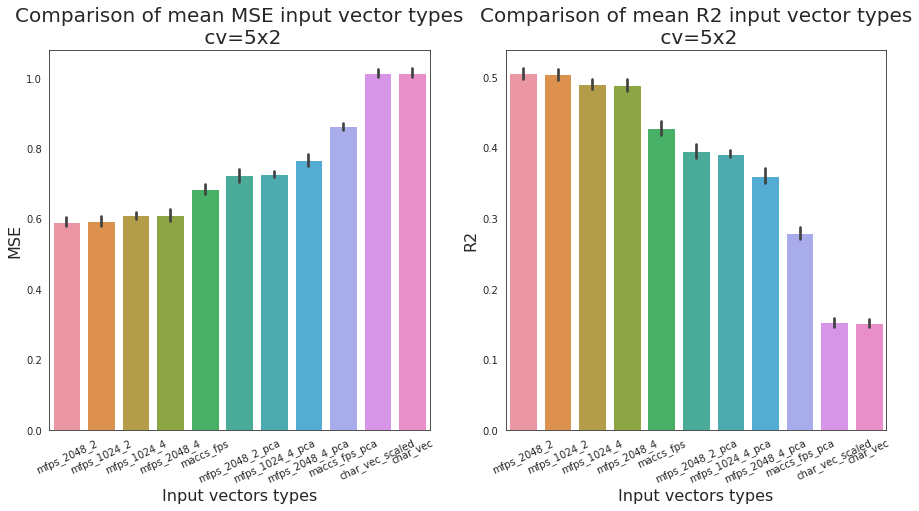

In [69]:
# let's make results tables
df_results_mse = pd.DataFrame(np.abs(scores_mse)).T
df_results_mse.columns = columns
df_res_mse_mean_std = pd.DataFrame({'mean MSE':df_results_mse.mean(),
                       'std MSE':df_results_mse.std()}).sort_values('mean MSE')
cols_sorted_by_mse = df_res_mse_mean_std.index
df_results_mse = df_results_mse[cols_sorted_by_mse]

df_results_r2 = pd.DataFrame(np.abs(scores_r2)).T
df_results_r2.columns = columns
df_res_r2_mean_std = pd.DataFrame({'mean R2':df_results_r2.mean(),
                       'std R2':df_results_r2.std()}).sort_values('mean R2')
#cols_sorted_by_r2 = df_res_r2_mean_std.index
df_results_r2 = df_results_r2[cols_sorted_by_mse]

tables = [df_results_mse, df_results_r2]

# Now let's plot the content of the tables
plt.figure(figsize=(15,7))
sns.set_style("white")
sns.set_palette('viridis')
    
for i, metrics in enumerate(['MSE', 'R2']):
    plt.subplot(1, 2, i+1)
    df_res_melted = pd.melt(tables[i], value_name=metrics, var_name='vec_type')
    sns.barplot(data=df_res_melted, x='vec_type', y=metrics)
    plt.ylabel(metrics,  fontsize=16)
    plt.xlabel('Input vectors types',  fontsize=16)
    plt.title('Comparison of mean '+metrics+' of input vector types\n cv=5x2', fontsize=20)
    plt.xticks(rotation=25)

 
plt.show()

In [36]:
df_res_mean_std

,mean MSE,std MSE
mfps_2048_2,0.534641,0.016397
mfps_1024_2,0.535977,0.019268
mfps_2048_4,0.540405,0.017045
mfps_1024_4,0.548256,0.020477
maccs_fps,0.578851,0.023511
mfps_2048_2_pca,0.617153,0.013727
mfps_1024_4_pca,0.625716,0.017885
mfps_1024_4_pca,0.627638,0.015568
mfps_2048_4_pca,0.628704,0.020475
maccs_fps_pca,0.682336,0.021236


In [ ]:
df_results_testset = pd.DataFrame({'MSE testset': np.array(all_test_scores)[:,0],
                                   'R2 testset': np.array(all_test_scores)[:,1],})
df_results_testset.index = columns
df_results_testset.sort_values('MSE testset')
df_results_testset

### Target value transformation

Let's use the same script and data with just small adjustment of normalization of target value

In [41]:
all_scores = []
all_models = []
all_test_scores = []
all_test_X = []
scaler = MinMaxScaler()
scaler_y = StandardScaler()
fps_types = ['char_vec', 'char_vec', 'maccs_fps', 'maccs_fps', 
            'mfps_1024_2', 'mfps_1024_4', 'mfps_2048_2', 'mfps_2048_4',
            'mfps_1024_2', 'mfps_1024_4', 'mfps_2048_2', 'mfps_2048_4']
counter = 0
to_pca = [3, 8, 9, 10, 11]
to_transform = [1]

scorings = ('r2', 'neg_mean_squared_error')
cv = RepeatedKFold(n_splits=2, n_repeats=5, random_state=0)
    
for fp_type in fps_types:
    
    X = [val for val in df_filtered[fp_type]]
    y = df_filtered.ds.to_numpy()
    train_X, test_X, train_y, test_y = train_test_split(X, y,
                      test_size = 0.3, random_state = 0)
    
    # transformation of the target value
    # we can reuse fited scaler to transform other test data or transform data back
    train_y = scaler_y.fit_transform(train_y.reshape(-1, 1))
    test_y = scaler_y.transform(test_y.reshape(-1, 1))      
    
    # transformation of the input vectors
    if counter in to_transform:
        train_X = scaler.fit_transform(train_X)
        test_X = scaler.transform(test_X)
        
    if counter in to_pca:
        train_X = pca.fit_transform(train_X)
        test_X = pca.transform(test_X)
    
    # get model with best hyperparameters
    model = get_tuned_model(train_X, train_y)
    
    # evaluate the model using cv
    scores = cross_validate(model, train_X, train_y, scoring=scorings, cv=cv, n_jobs=-1)
    all_scores.append(scores)
    
    # train the model on the whole trainset and get results for the testset
    model.fit(train_X, train_y)
    preds = model.predict(test_X)
    all_test_X.append(test_X)
    all_test_scores.append([mean_squared_error(test_y, preds), r2_score(test_y, preds)])
    all_models.append(model)
    counter += 1

Fitting 5 folds for each of 5 candidates, totalling 25 fits
best params for fp type char_vec {'subsample': 0.8, 'n_estimators': 600, 'min_child_weight': 10, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 0.8}
best score 0.668
Fitting 5 folds for each of 5 candidates, totalling 25 fits
best params for fp type char_vec {'subsample': 0.8, 'n_estimators': 600, 'min_child_weight': 10, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 0.8}
best score 0.664
Fitting 5 folds for each of 5 candidates, totalling 25 fits
best params for fp type maccs_fps {'subsample': 0.8, 'n_estimators': 600, 'min_child_weight': 10, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 0.8}
best score 0.532
Fitting 5 folds for each of 5 candidates, totalling 25 fits
best params for fp type maccs_fps {'subsample': 0.8, 'n_estimators': 600, 'min_child_weight': 10, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 0.8}
best score 0.610
Fitting 5 folds for each of 5 candidates, totalling 25 fits
best params for fp typ

/home/clarovak/.conda/envs/adapters-trf/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


best params for fp type mfps_2048_4 {'subsample': 0.8, 'n_estimators': 600, 'min_child_weight': 10, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 0.8}
best score 0.498
[CV 4/5] END colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=1, n_estimators=500, subsample=0.6;, score=-0.697 total time= 2.5min
[CV 5/5] END colsample_bytree=0.8, gamma=0.1, max_depth=3, min_child_weight=5, n_estimators=300, subsample=0.8;, score=-0.677 total time= 1.6min
[CV 2/5] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8;, score=-0.572 total time=  34.7s
[CV 1/5] END colsample_bytree=0.8, gamma=0.5, max_depth=4, min_child_weight=10, n_estimators=600, subsample=0.8;, score=-0.540 total time= 2.7min
[CV 4/5] END colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=1, n_estimators=500, subsample=0.6;, score=-0.656 total time= 2.3min
[CV 3/5] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=1, n_estimators=100, subsa

/home/clarovak/.conda/envs/adapters-trf/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 5/5] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8;, score=-0.686 total time=  35.6s
[CV 3/5] END colsample_bytree=0.8, gamma=0.5, max_depth=4, min_child_weight=10, n_estimators=600, subsample=0.8;, score=-0.682 total time= 2.2min
[CV 4/5] END colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=1, n_estimators=500, subsample=0.6;, score=-0.691 total time= 2.5min
[CV 1/5] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8;, score=-0.609 total time=  37.0s
[CV 2/5] END colsample_bytree=0.8, gamma=0.5, max_depth=4, min_child_weight=10, n_estimators=600, subsample=0.8;, score=-0.523 total time= 2.7min
[CV 5/5] END colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=1, n_estimators=500, subsample=0.6;, score=-0.616 total time= 2.2min
[CV 2/5] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8;, score=-0.524 to

In [42]:
scores_mse = [s['test_neg_mean_squared_error'] for s in all_scores]
scores_r2 = [s['test_r2'] for s in all_scores]
columns = ['char_vec', 'char_vec_scaled', 'maccs_fps', 'maccs_fps_pca', 
            'mfps_1024_2', 'mfps_1024_4', 'mfps_2048_2', 'mfps_2048_4',
            'mfps_1024_4_pca', 'mfps_1024_4_pca', 'mfps_2048_2_pca', 'mfps_2048_4_pca']

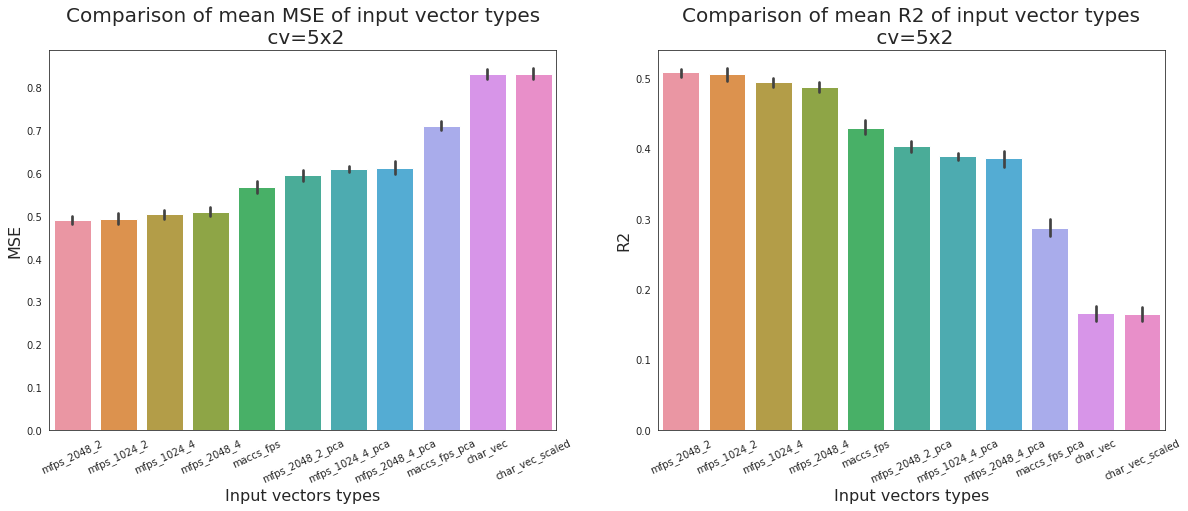

In [43]:
# let's make results tables
df_results_mse = pd.DataFrame(np.abs(scores_mse)).T
df_results_mse.columns = columns
df_res_mse_mean_std = pd.DataFrame({'mean MSE':df_results_mse.mean(),
                       'std MSE':df_results_mse.std()}).sort_values('mean MSE')
cols_sorted_by_mse = df_res_mse_mean_std.index
df_results_mse = df_results_mse[cols_sorted_by_mse]

df_results_r2 = pd.DataFrame(np.abs(scores_r2)).T
df_results_r2.columns = columns
df_res_r2_mean_std = pd.DataFrame({'mean R2':df_results_r2.mean(),
                       'std R2':df_results_r2.std()}).sort_values('mean R2')
#cols_sorted_by_r2 = df_res_r2_mean_std.index
df_results_r2 = df_results_r2[cols_sorted_by_mse]

tables = [df_results_mse, df_results_r2]

# Now let's plot the content of the tables
plt.figure(figsize=(20,7))
sns.set_style("white")
sns.set_palette('viridis')
    
for i, metrics in enumerate(['MSE', 'R2']):
    plt.subplot(1, 2, i+1)
    df_res_melted = pd.melt(tables[i], value_name=metrics, var_name='vec_type')
    sns.barplot(data=df_res_melted, x='vec_type', y=metrics)
    plt.ylabel(metrics,  fontsize=16)
    plt.xlabel('Input vectors types',  fontsize=16)
    plt.title('Comparison of mean '+metrics+' of input vector types\n cv=5x2', fontsize=20)
    plt.xticks(rotation=25)

 
plt.show()

In [44]:
print(df_res_mse_mean_std), print(df_res_r2_mean_std)

                 mean MSE   std MSE
mfps_2048_2      0.490743  0.017755
mfps_1024_2      0.493677  0.022906
mfps_1024_4      0.504896  0.017051
mfps_2048_4      0.511324  0.017333
maccs_fps        0.569697  0.023864
mfps_2048_2_pca  0.595733  0.022248
mfps_1024_4_pca  0.603151  0.018347
mfps_2048_4_pca  0.613222  0.027170
mfps_1024_4_pca  0.617011  0.024560
maccs_fps_pca    0.711863  0.017064
char_vec         0.833401  0.022097
char_vec_scaled  0.833871  0.021200
                  mean R2    std R2
char_vec_scaled  0.165982  0.018638
char_vec         0.166482  0.018336
maccs_fps_pca    0.287894  0.019985
mfps_1024_4_pca  0.382991  0.019585
mfps_2048_4_pca  0.386894  0.019465
mfps_1024_4_pca  0.396896  0.008892
mfps_2048_2_pca  0.404350  0.014141
maccs_fps        0.430406  0.016486
mfps_2048_4      0.488692  0.012045
mfps_1024_4      0.495149  0.010333
mfps_1024_2      0.506439  0.016277
mfps_2048_2      0.509336  0.009886


(None, None)

In [45]:
df_results_testset = pd.DataFrame({'MSE testset': np.array(all_test_scores)[:,0],
                                   'R2 testset': np.array(all_test_scores)[:,1],})
df_results_testset.index = columns
df_results_testset.sort_values('MSE testset')
df_results_testset

,MSE testset,R2 testset
char_vec,0.714499,0.284519
char_vec_scaled,0.693489,0.305559
maccs_fps,0.471023,0.528331
maccs_fps_pca,0.625571,0.373570
mfps_1024_2,0.411992,0.587442
mfps_1024_4,0.424105,0.575313
mfps_2048_2,0.413865,0.585567
mfps_2048_4,0.425371,0.574045
mfps_1024_4_pca,0.523371,0.475911
mfps_1024_4_pca,0.533920,0.465347


0.5057205672782712

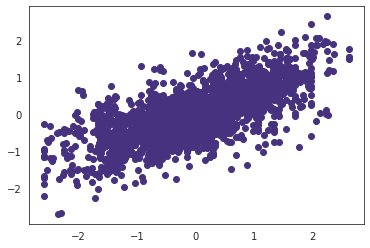

[CV 2/5] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8;, score=-0.569 total time=  46.9s
[CV 3/5] END colsample_bytree=0.8, gamma=0.5, max_depth=4, min_child_weight=10, n_estimators=600, subsample=0.8;, score=-0.577 total time= 3.1min
[CV 4/5] END colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=1, n_estimators=500, subsample=0.6;, score=-0.589 total time= 3.9min
[CV 3/5] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8;, score=-0.588 total time=  50.2s
[CV 1/5] END colsample_bytree=0.8, gamma=0.5, max_depth=4, min_child_weight=10, n_estimators=600, subsample=0.8;, score=-0.584 total time= 3.4min
[CV 4/5] END colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=1, n_estimators=500, subsample=0.6;, score=-0.563 total time= 4.5min
[CV 1/5] END colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=5, n_estimators=500, subsample=0.8;, score=-0.523 tota

In [47]:
n = -1
ppp = all_models[n].predict(all_test_X[n])
plt.scatter(test_y, ppp)
r2_score(test_y, ppp)

# CLASSIFICATION on regression data

In [103]:
from xgboost import XGBClassifier
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score, accuracy_score, make_scorer

oversample = SMOTE()
f1 = make_scorer(f1_score , average='weighted')

We can convert regression task to classification by binning the data and predicting the bin as a class

<AxesSubplot:>

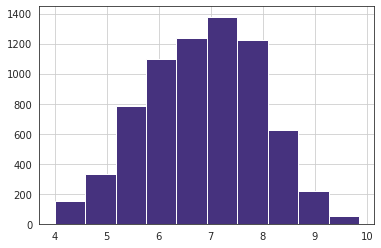

In [49]:
# let's see how the ds values are distributed
df_filtered.ds.hist()

In [62]:
bins = pd.cut(df_filtered.ds, bins=np.arange(4,11),
                      labels=np.arange(4,10))
df_filtered['bins'] = bins
df_filtered.bins.value_counts()

7    2285
6    2075
5    1392
8     918
4     299
9      86
Name: bins, dtype: int64

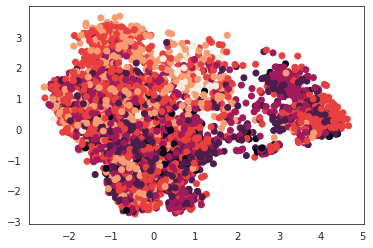

In [64]:
# We can see that the classes (bins) are imbalanced
# Let's try to predict with imbalanced distribution and then let's try to balanced the data
# First let's look at the classes in the plot
pca_emb = pca.fit_transform([f for f in df_filtered.mfps_2048_2])

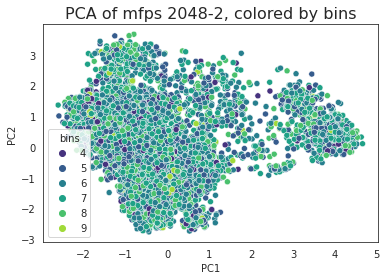

In [69]:
df_components = pd.DataFrame({'PC1': pca_emb[:,0],
                             'PC2': pca_emb[:,1]})
sns.scatterplot(data=df_components, x='PC1', y='PC2', hue=df_filtered.bins)
plt.title('PCA of mfps 2048-2, colored by bins', fontsize=16)
plt.show()

In [111]:
def get_tuned_model(X, y,):      
    params = {
            'min_child_weight': [1, 5, 10],
            'gamma': [0.1, 0.5, 1, 1.5,],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'n_estimators' : [300, 400, 500, 600, 700],
            'max_depth': [3, 4, 5]
            }
    
    xg_clf = XGBClassifier(objective='multi:softmax', seed=0)
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    random_search = RandomizedSearchCV(xg_clf, 
                                       param_distributions=params, 
                                       n_iter=5,
                                       scoring=f1, 
                                       n_jobs=-1, 
                                       cv=kf, 
                                       verbose=3, 
                                       random_state=0)

    # train the model on the whole trainset
    random_search.fit(X, y)
    print('best params for fp type ' + fp_type, random_search.best_params_)
    print('best score %.3f' %(np.abs(random_search.best_score_)))
          
    return random_search.best_estimator_

In [112]:
all_scores = []
all_test_scores = []
all_test_X = []
all_clf_models = []
fps_types = ['mfps_2048_2', 'mfps_2048_2']
counter = 0
le = preprocessing.LabelEncoder()
cv = RepeatedKFold(n_splits=2, n_repeats=5, random_state=0)
    
for fp_type in fps_types:
    
    X = [val for val in df_filtered[fp_type]]
    le.fit(df_filtered.bins)
    y = le.transform(df_filtered.bins)
    train_X, test_X, train_y, test_y = train_test_split(X, y,
                      test_size = 0.3, random_state = 0)
           
    train_X = pca.fit_transform(train_X)
    test_X = pca.transform(test_X)
    
    if counter == 1:
        train_X, train_y = oversample.fit_resample(train_X, train_y)
    
    # get model with best hyperparameters
    model = get_tuned_model(train_X, train_y)
    
    # evaluate the model using cv
    scores = cross_validate(model, train_X, train_y, scoring=f1, cv=cv, n_jobs=-1)
    all_scores.append(scores)
    
    # get results for the testset
    preds = model.predict(test_X)
    all_test_X.append(test_X)
    all_test_scores.append([f1_score(test_y, preds, average='weighted'), accuracy_score(test_y, preds)])
    all_clf_models.append(model)
    counter += 1

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 4/5] END colsample_bytree=0.8, gamma=0.1, max_depth=3, min_child_weight=5, n_estimators=400, subsample=0.8;, score=0.542 total time=17.2min
[CV 3/5] END colsample_bytree=0.8, gamma=0.1, max_depth=3, min_child_weight=5, n_estimators=400, subsample=0.8;, score=0.569 total time=17.3min
[CV 5/5] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=1, n_estimators=300, subsample=0.8;, score=0.537 total time=17.4min
[CV 2/5] END colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=5, n_estimators=600, subsample=0.8;, score=0.530 total time=21.6min
[CV 2/5] END colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=1, n_estimators=600, subsample=0.6;, score=0.511 total time=22.7min
[CV 3/5] END colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=5, n_estimators=600, subsample=0.8;, score=0.544 total time=25.1min
[CV 1/5] END colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=5, n_e

Let's look whether the oversampling helped

In [114]:
# imbalanced data test set
df_all_test_scores = pd.DataFrame(all_test_scores)
df_all_test_scores.columns = ['wgth F1', 'acc']
df_all_test_scores.index = ['imbalanced', 'balanced']
df_all_test_scores

,wgth F1,acc
imbalanced,0.537944,0.543703
balanced,0.550877,0.551692


In [118]:
# let's make results tables
df_results_f1 = pd.DataFrame([s['test_score'] for s in all_scores]).T
df_results_f1.columns = ['imbalanced', 'balanced']
df_res_f1_mean_std = pd.DataFrame({'mean F1':df_results_f1.mean(),
                       'std F1':df_results_f1.std()})

df_res_f1_mean_std

,mean F1,std F1
imbalanced,0.506071,0.011231
balanced,0.806365,0.004890


Notice the difference on crossvalidated data from the oversampled set and test set. Allways oversample only the taining set and keep the testset untouched.
Now, look at the confusion matrices, the first is for tne imbalanced data and the second for the balanced, and compare them.

In [116]:
n = 0
preds = all_clf_models[n].predict(all_test_X[n])
cm = confusion_matrix(test_y, preds)
cm

array([[ 19,  34,  16,  10,   0,   0,   2],
       [ 12, 212, 122,  70,   3,   0,   0],
       [  2,  93, 366, 165,  12,   0,   4],
       [  0,  32, 138, 427,  59,   0,   0],
       [  0,   4,  23, 138, 121,   7,   0],
       [  0,   2,   1,   6,  11,   7,   0],
       [  0,   4,   1,   0,   0,   0,   5]])

In [117]:
n = 1
preds = all_clf_models[n].predict(all_test_X[n])
cm = confusion_matrix(test_y, preds)
cm

array([[ 32,  19,  17,  10,   0,   0,   3],
       [ 20, 232, 103,  57,   3,   1,   3],
       [ 10, 123, 339, 147,  20,   0,   3],
       [  4,  39, 124, 401,  88,   0,   0],
       [  0,   2,  17, 105, 152,  17,   0],
       [  0,   1,   2,   4,   8,  12,   0],
       [  1,   2,   0,   1,   0,   0,   6]])